# Multi Head Latent Attention 
introduced in deepseek v2 and uses latent matrices (down projection) of KV and Q to reduce KVCache size.   
[Arxiv](https://arxiv.org/pdf/2405.04434)  

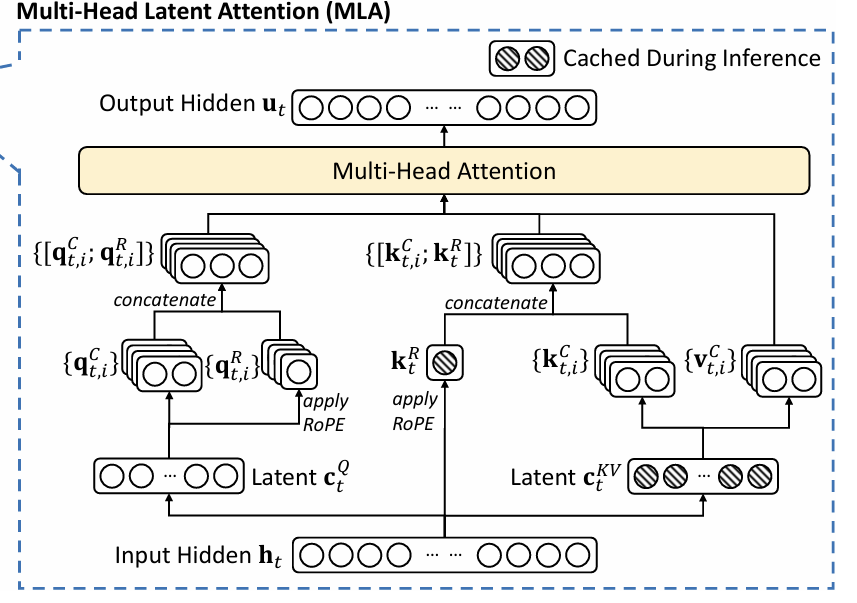

In [1]:
import torch 
import torch.nn as nn 

## Simple MLA : Without decoupled ROPE

In [9]:
class MLAnoRoPE(nn.Module):
    def __init__(self, d_model, d_emb, num_heads, Ckv, dropout=0.1):
        super().__init__()   
    
        assert d_model % num_heads == 0, "Num heads should be divisible by d_model"
        self.d_model = d_model
        self.d_emb = d_emb  
        self.num_heads = num_heads
        self.Ckv = Ckv # latent dim 
        self.head_dim = d_model // num_heads 

        # porjections 
        self.W_q = nn.Linear(d_emb, d_model, bias=False)
        self.W_DKV = nn.Linear(d_emb, Ckv, bias=False)
        self.W_UK = nn.Linear(Ckv, d_model, bias=False)
        self.W_UV = nn.Linear(Ckv, d_model, bias=False)

        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

        # caching kv 
        self.register_buffer('kv_cache', None, persistent=None) # not part of state_dict 
        self.pos = 0 # keep track of tokens processed 

    def forward(self, x , use_cache=True):
        batch, seq, _ = x.shape 

        Q = self.W_q(x)
        # down projections 
        C_KV = self.W_DKV(x)

        if use_cache: 
            if self.kv_cache is None: 
                C_KV_total = C_KV 
            else: 
                C_KV_total = torch.cat(self.kv_cache, C_KV, dim=1)
            self.kv_cache = C_KV_total 
        else: 
            C_KV_total = C_KV 

        # up projections 
        K = self.W_UK(C_KV_total) # batch, Ckv, d_model 
        V = self.W_UV(C_KV_total)

        Q = Q.view(batch, seq, self.num_heads, self.head_dim).transpose(1,2)

        C_KV_len = C_KV_total.shape[1]
        K = K.view(batch , C_KV_len, self.num_heads, self.head_dim).transpose(1,2)
        V = V.view(batch , C_KV_len, self.num_heads, self.head_dim).transpose(1,2)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1))

        tokens_Q = Q.shape[-2]
        tokens_K = K.shape[-2] 

        # creating mask 
        if use_cache:
            Q_postitions = torch.arange(self.pos, self.pos+tokens_Q, device=Q.device)
            self.pos += tokens_Q 
        else: 
            Q_postitions = torch.arange(tokens_Q, device=Q.device)
            self.pos = 0 
        K_positions = torch.arange(tokens_K, device=Q.device)
        mask_bool = Q_postitions.unsqueeze(-1) < K_positions.unsqueeze(0) # tokens_q, tokens_k mask

        attn_scores = attn_scores.masked_fill(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / K.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        cntxt = (attn_weights @ V).transpose(1,2).contiguous()
        cntxt = cntxt.view(batch, seq, self.d_model)
        out = self.out_proj(cntxt)

        return out




In [12]:
d_emb = 16 
d_model = 32 
num_heads = 4 
Ckv_dim =  8

model = MLAnoRoPE(d_model, d_emb, num_heads, Ckv_dim)

batch = 2 
seq = 10 

x = torch.randn(batch, seq, d_emb)

out = model(x, use_cache=False)
print(f"shape wo kvCache : {out.shape}")

out = model(x, use_cache=True)
print(f"shape w kvCache : {out.shape}")


shape wo kvCache : torch.Size([2, 10, 32])
shape w kvCache : torch.Size([2, 10, 32])


In [13]:
class MLAnoRoPE_V2(nn.Module):
    "also down projection Q"
    def __init__(self, d_model, d_emb, num_heads, Ckv, Cq, dropout=0.1):
        super().__init__()   
    
        assert d_model % num_heads == 0, "Num heads should be divisible by d_model"
        self.d_model = d_model
        self.d_emb = d_emb  
        self.num_heads = num_heads
        self.Ckv = Ckv # latent dim 
        self.Cq = Cq 
        self.head_dim = d_model // num_heads 

        # down porjections 
        self.W_DQ = nn.Linear(d_emb, Cq, bias=False)
        self.W_DKV = nn.Linear(d_emb, Ckv, bias=False)

        # up projections
        self.W_UK = nn.Linear(Ckv, d_model, bias=False)
        self.W_UV = nn.Linear(Ckv, d_model, bias=False)
        self.W_UQ = nn.Linear(Cq, d_model, bias=False)

        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

        # caching kv 
        self.register_buffer('kv_cache', None, persistent=None) # not part of state_dict 
        self.pos = 0 # keep track of tokens processed 

    def forward(self, x , use_cache=True):
        batch, seq, _ = x.shape 

        C_Q = self.W_DQ(x)
        # down projections 
        C_KV = self.W_DKV(x)

        if use_cache: 
            if self.kv_cache is None: 
                C_KV_total = C_KV 
            else: 
                C_KV_total = torch.cat(self.kv_cache, C_KV, dim=1)
            self.kv_cache = C_KV_total 
        else: 
            C_KV_total = C_KV 

        # up projections 
        Q = self.W_UQ(C_Q)
        K = self.W_UK(C_KV_total) # batch, Ckv, d_model 
        V = self.W_UV(C_KV_total)

        Q = Q.view(batch, seq, self.num_heads, self.head_dim).transpose(1,2)

        C_KV_len = C_KV_total.shape[1]
        K = K.view(batch , C_KV_len, self.num_heads, self.head_dim).transpose(1,2)
        V = V.view(batch , C_KV_len, self.num_heads, self.head_dim).transpose(1,2)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1))

        tokens_Q = Q.shape[-2]
        tokens_K = K.shape[-2] 

        # creating mask 
        if use_cache:
            Q_postitions = torch.arange(self.pos, self.pos+tokens_Q, device=Q.device)
            self.pos += tokens_Q 
        else: 
            Q_postitions = torch.arange(tokens_Q, device=Q.device)
            self.pos = 0 
        K_positions = torch.arange(tokens_K, device=Q.device)
        mask_bool = Q_postitions.unsqueeze(-1) < K_positions.unsqueeze(0) # tokens_q, tokens_k mask

        attn_scores = attn_scores.masked_fill(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / K.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        cntxt = (attn_weights @ V).transpose(1,2).contiguous()
        cntxt = cntxt.view(batch, seq, self.d_model)
        out = self.out_proj(cntxt)

        return out




In [14]:
d_emb = 16 
d_model = 32 
num_heads = 4 
Ckv_dim =  8
Cq_dim = 8

model = MLAnoRoPE_V2(d_model, d_emb, num_heads, Ckv_dim, Cq_dim)

batch = 2 
seq = 10 

x = torch.randn(batch, seq, d_emb)

out = model(x, use_cache=False)
print(f"shape wo kvCache : {out.shape}")

out = model(x, use_cache=True)
print(f"shape w kvCache : {out.shape}")


shape wo kvCache : torch.Size([2, 10, 32])
shape w kvCache : torch.Size([2, 10, 32])
